In [23]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import keras
import missingno
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [5]:
train_pd = pd.read_csv(r"C:\Users\HP\Downloads\house-prices-advanced-regression-techniques/train.csv")
test_pd = pd.read_csv(r"C:\Users\HP\Downloads\house-prices-advanced-regression-techniques/test.csv")
train_pd.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Axes: >

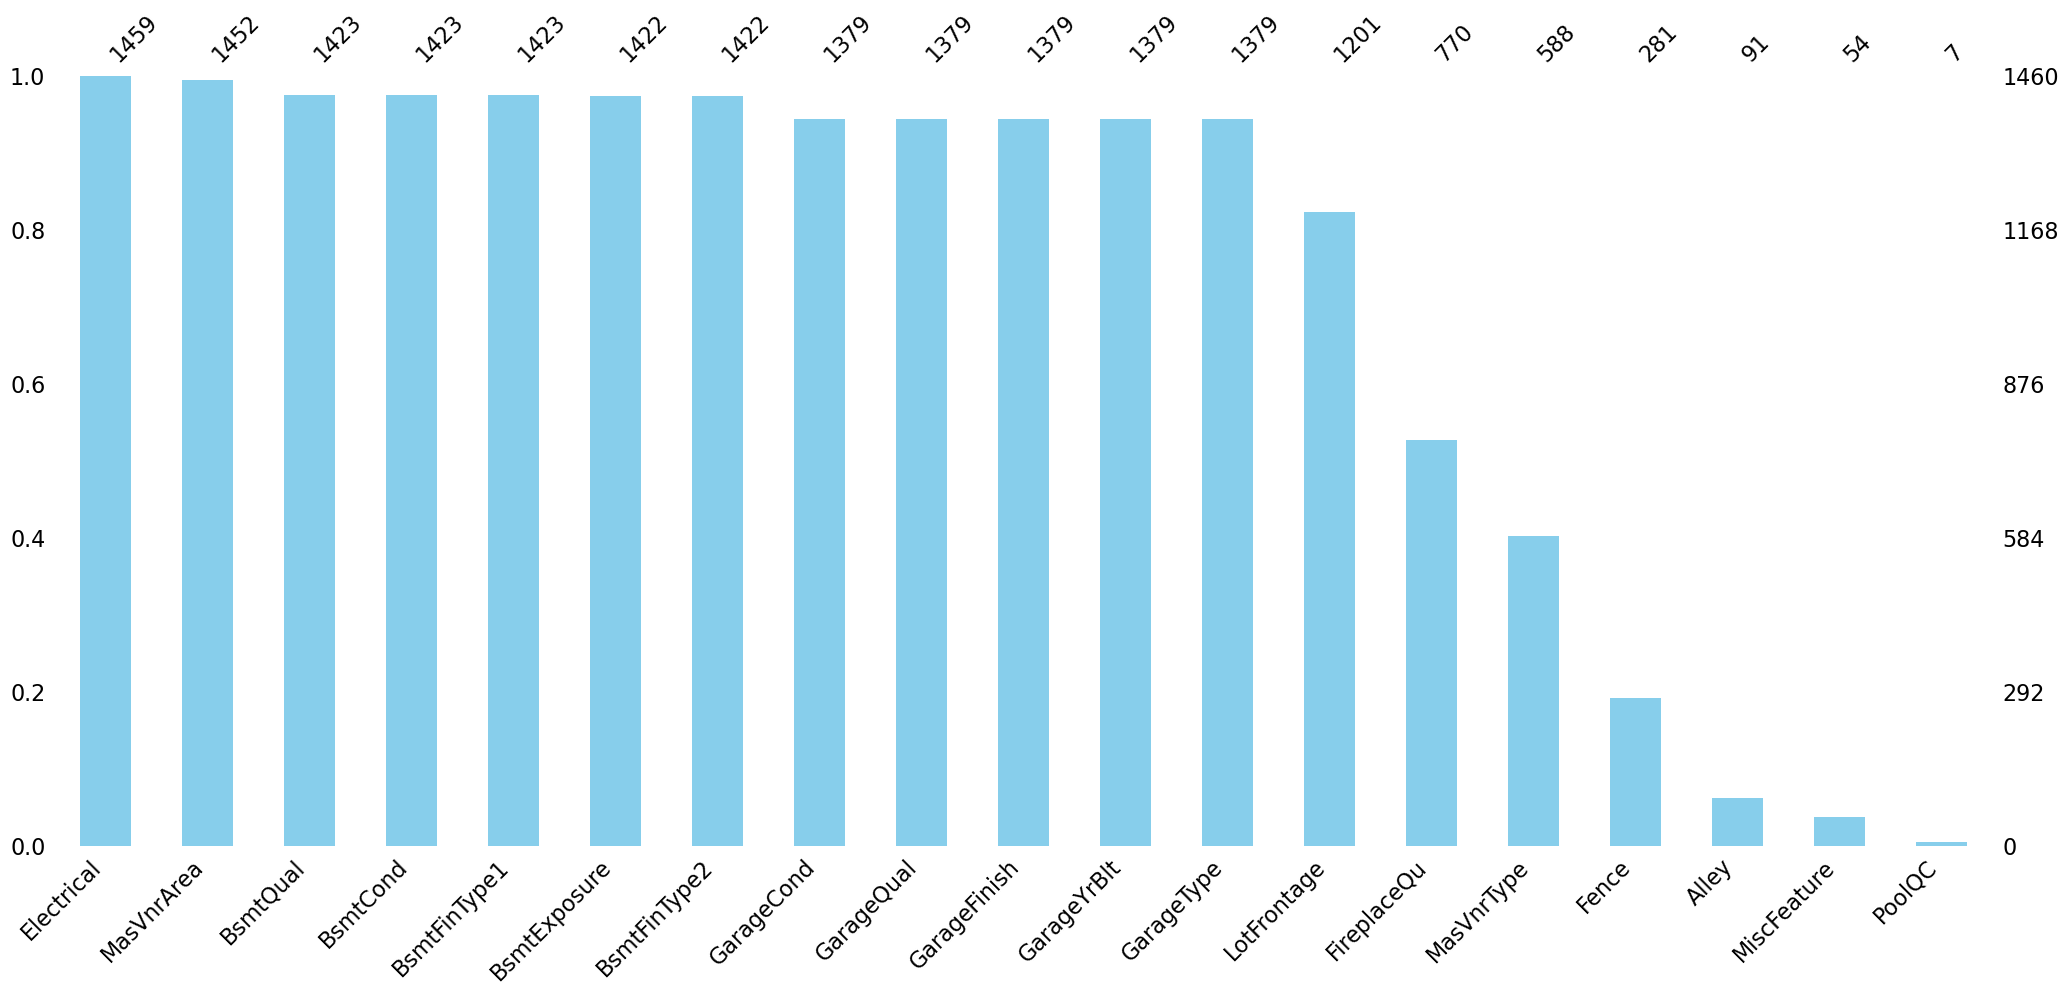

In [12]:
l1 = train_pd.columns[train_pd.isnull().any()]
missingno.bar(train_pd[l1], sort="descending", color='skyblue')

<Axes: >

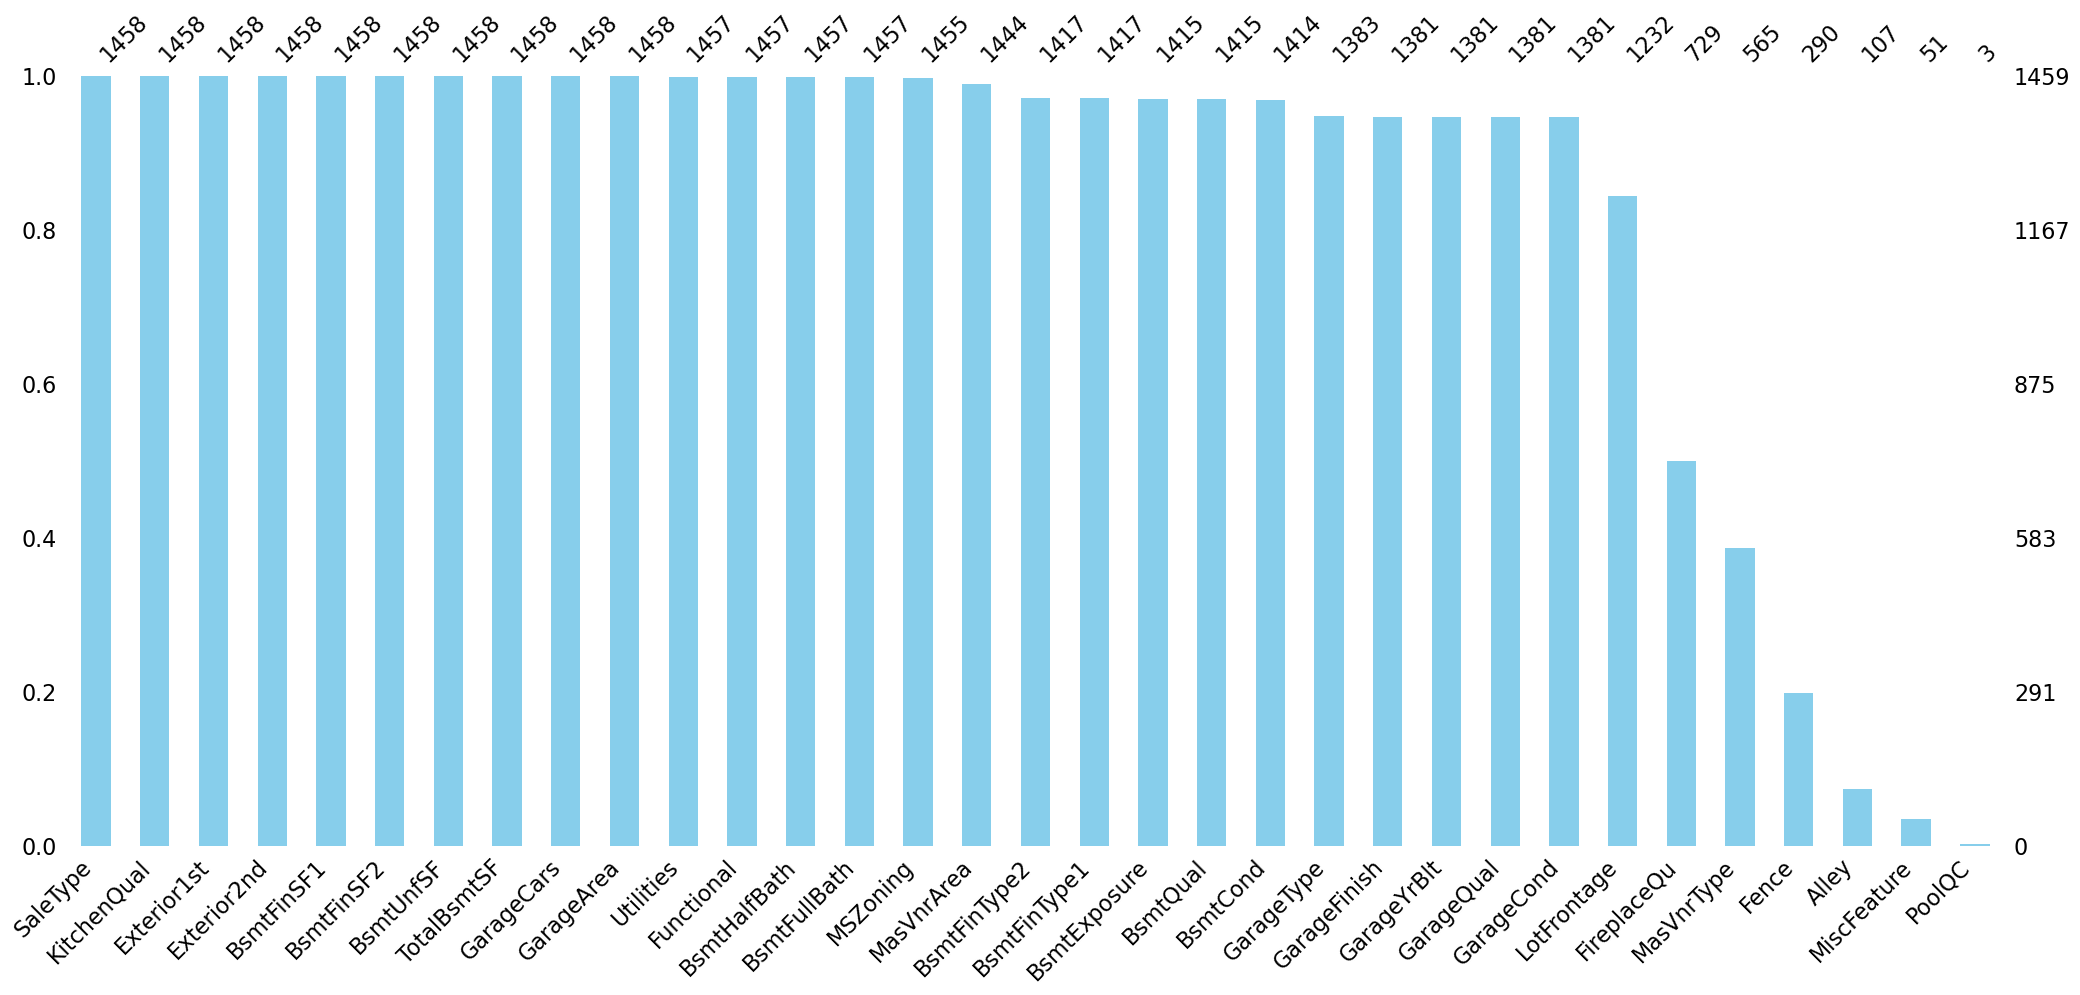

In [13]:
l2 = test_pd.columns[test_pd.isnull().any()]
missingno.bar(test_pd[l2], sort="descending", color='skyblue')

In [17]:
def drop_columns(df):
    useless_columns = ["PoolQC", "MiscFeature", "Alley", 
                       "Fence", "MasVnrType", "FireplaceQu"]
    return df.drop(useless_columns, axis=1)

def fill_missing_values(df):
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].fillna("None")
        else:
            df[col] = df[col].fillna(0)
    return df

def encode_categorical_data(df):
    for col in df.columns:
        if df[col].dtype == "object":
            encoder = OrdinalEncoder()
            df[col] = encoder.fit_transform(df[col].values.reshape(-1, 1))
    return df

def preprocess_data(df):
    df = drop_columns(df)
    df = fill_missing_values(df)
    df = encode_categorical_data(df)
    return df

train_pd = train_pd.drop("Id", axis=1)
train_pd = preprocess_data(train_pd)
test_pd = preprocess_data(test_pd)

In [18]:
X = train_pd.drop("SalePrice", axis =1)
y = train_pd["SalePrice"]
scaler = StandardScaler()
y = np.log(y)
X = scaler.fit_transform(X)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size =0.2, random_state =42)
print(X.shape)
print(X_train, y_train)

(1460, 73)
[[-0.87256276 -0.04553194  0.35716722 ...  1.64520971  0.31386709
   0.2085023 ]
 [ 0.07337496 -0.04553194  0.03972917 ...  0.8919936   0.31386709
   0.2085023 ]
 [-0.63607833 -0.04553194  0.27059321 ...  0.13877749  0.31386709
   0.2085023 ]
 ...
 [-0.87256276 -0.04553194  0.06858717 ... -1.36765473  0.31386709
   0.2085023 ]
 [-0.16310947 -0.04553194 -0.07570285 ... -0.61443862  0.31386709
   0.2085023 ]
 [ 1.49228154 -0.04553194 -0.13341886 ...  0.8919936   0.31386709
   0.2085023 ]] 254     11.884489
1066    12.089539
638     11.350407
799     12.072541
380     11.751942
          ...    
1095    12.080691
1130    11.813030
1294    11.652687
860     12.154516
1126    12.066811
Name: SalePrice, Length: 1168, dtype: float64


In [21]:
model = keras.Sequential([
    keras.layers.Dense(10, activation ='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1)
])

model.compile(optimizer = keras.optimizers.Adam(), loss ='mse')

In [24]:
batch_size =32
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size)

In [25]:
model.fit(train_data, epochs =100)

Epoch 1/100

37/37 [==============================] - 2s 4ms/step - loss: 143.7923
Epoch 2/100
37/37 [==============================] - 0s 4ms/step - loss: 139.7335
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 134.7401
Epoch 4/100
37/37 [==============================] - 0s 3ms/step - loss: 128.4383
Epoch 5/100
37/37 [==============================] - 0s 4ms/step - loss: 120.8970
Epoch 6/100
37/37 [==============================] - 0s 4ms/step - loss: 112.2857
Epoch 7/100
37/37 [==============================] - 0s 3ms/step - loss: 102.8286
Epoch 8/100
37/37 [==============================] - 0s 4ms/step - loss: 92.7779
Epoch 9/100
37/37 [==============================] - 0s 4ms/step - loss: 82.4079
Epoch 10/100
37/37 [==============================] - 0s 4ms/step - loss: 71.9939
Epoch 11/100
37/37 [==============================] - 0s 3ms/step - loss: 61.8018
Epoch 12/100
37/37 [==============================] - 0s 4ms/step - loss: 52.0730
Epoch 13/100
37/3

37/37 [==============================] - 0s 4ms/step - loss: 0.0207
Epoch 100/100
37/37 [==============================] - 0s 4ms/step - loss: 0.0206


In [26]:
model.evaluate(valid_data)

10/10 [==============================] - 0s 4ms/step - loss: 0.0697


0.06967625766992569

In [30]:
X_test = test_pd.drop("Id", axis=1)
X_test = X_test.values
print(X_test.shape)
X_test = scaler.transform(X_test)
y_test = model.predict(X_test)
y_test = np.exp(y_test)
submission = pd.DataFrame({'Id': test_pd['Id'], 'SalePrice': y_test.flatten()})
output_dir = '/kaggle/working'

(1459, 73)
22/46 [=============>................] - ETA: 0s

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


46/46 [==============================] - 0s 2ms/step
